# Imports

In [20]:
import os
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import random as r
import matplotlib.pyplot as plt
import glob
import torchvision
import cv2
import scienceplots
import sys

sys.path.append('../')

from src.utils import name_match
from src.utils.metrics import forgetting_table, forgetting_line, forgetting, raa, raf, get_rand_perfs

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['text.usetex'] = False
%matplotlib inline

latex_columnwidth_in_cm = 8.6
figure_aspect_ratio = 4/6

latex_columnwidth_in_pt = latex_columnwidth_in_cm/2.54

# plt.style.use(['science','grid']) # pip3 install SciencePlots --user

plt.rc('figure', dpi=150, figsize=[latex_columnwidth_in_pt, latex_columnwidth_in_pt*(4/6)])
# plt.rc('font', size=8, serif='Times')
plt.rc('savefig', pad_inches=0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda', index=0)

# Get legend

In [21]:
def get_legend(method):
    legend = {
        "2aug": {
            "label"     : 'SimCLR',
            "linestyle" : 'dashed',
            "marker"    :  'o',
            "color"     :   'C0'
        },
        "er": {
            "label"     : 'ER',
            "linestyle" : 'solid',
            "marker"    :  'v',
            "color"     :  'C1'
        },
        "gdumb": {
            "label"     : 'GDumb',
            "linestyle" : 'solid',
            "marker"    :  '^',
            "color"     :  'C2'
        },
        "agem": {
            "label"     : 'AGEM',
            "linestyle" : 'solid',
            "marker"    :  'p',
            "color"     :  'C3'
        },
        "scr": {
            "label"     : 'SCR',
            "linestyle" : 'dashed',
            "marker"    :  'x',
            "color"     :  'C4'
        },
        "lump": {
            "label"     : 'LUMP',
            "linestyle" : 'dashed',
            "marker"    :  '*',
            "color"     :  'C5'
        },
        "4aug,1mixup,1cutmix,1style": {
            "label"     :  'DAA (ours)',
            "linestyle" :  'dashed',
            "marker"    :  'd',
            "color"     :  'C6'
        },
        "finetune": {
            "label"     :  "fine-tuned",
            "linestyle" :  "solid",
            "marker"    :  "1",
            "color"     :  'C7'
        },
        "stam": {
            "label"     :  "STAM",
            "linestyle" :  "dashed",
            "marker"    :  "2",
            "color"     :  'C8'
        }
    }

    
    return legend[method]["label"], legend[method]["marker"], legend[method]["linestyle"], legend[method]["color"]

# loading data for plot

In [22]:
def load_data(
    tags=['2aug', 'gdumb', 'agem'],
    tags20=["4aug,1mixup,1cutmix,1style"],
    dataset='cifar10',
    n_classes=10,
    mi=1,
    mem_size=200,
    n_tasks=5,
    n_runs=5,
    data_root='../results/',
    metric='acc',  # choices=['fgt', 'acc', 'raa', 'raf']
    run_id=0
):
    data = {}
    exps = {}

    for t in tags:
        if t == 'stam':
            exps[t] = f'{data_root}{dataset}/{t},{dataset}/'
        elif t == 'gdumb':
            exps[t] = f'{data_root}{dataset}/{t},{dataset}_m{mem_size}epoch30/'
        elif t == 'finetune':
            exps[t] = f'{data_root}{dataset}/{t}/'
            #exps[t] = f'{data_root}{dataset}/{t},{dataset}_sbs10e1/'
        elif t == 'er':
            exps[t] = f'{data_root}{dataset}/{t},{dataset},mi{mi}_m{mem_size}mbs200sbs100e1/'
        else:
            if mi == -1:
                exps[t] = f'{data_root}{dataset}/{t}_m{mem_size}mbs200sbs100/'
            else:
                exps[t] = f'{data_root}{dataset}/{t},{dataset},mi{mi}_m{mem_size}mbs200sbs100/'

    # exp with 20 memory iterations
    for t in tags20:
        exps[t] = f'{data_root}{dataset}/{t},{dataset},mi20_m{mem_size}mbs200sbs100/'

    for key in exps:
        perf = get_perf(run_id, key, n_tasks, n_classes, metric, exps)
        if metric == 'fgt':
            perf = forgetting_table(perf, n_tasks)
        data[key] = np.expand_dims(perf.values, 0)

    for run_id in range(1, n_runs):
        for key in exps:
            perf = get_perf(run_id, key, n_tasks, n_classes, metric, exps)

            data[key] = np.concatenate((
                data[key],
                np.expand_dims(perf.values, 0)
            ))

    for method in data:
        y = np.nan_to_num(np.nanmean(data[method], axis=2))
        data[method] = y * 100

    return data

def get_perf(run_id, key, n_tasks, n_classes, metric, exps):
    clf = get_clf(key)
    try:
        filename = f"{exps[key]}run{run_id}/{clf}.csv"
        perf = pd.read_csv(filename)
        if metric == 'fgt':
            perf = forgetting_table(perf, n_tasks=n_tasks)
        if metric == 'raa':
            perf = raa(perf, n_tasks=n_tasks, n_classes=n_classes)
        if metric == 'raf':
            perf = raf(perf, n_tasks=n_tasks, n_classes=n_classes)
    except:
        print(f"File missing for {filename}")
        perf = pd.DataFrame(np.zeros((n_tasks, n_tasks)))
    
    return perf

def get_clf(key):
    if key in ['er', 'gdumb', 'agem', 'finetune']:
        clf = 'acc'
    elif key == 'stam':
        clf = 'topdown'
    else:
        clf = 'ncm'
    return clf

def get_rand_perfs(n_tasks, n_classes, metric):
    rand_perf = np.ones(n_tasks) / ((np.arange(n_tasks) + 1) * (n_classes // n_tasks))
    if metric == "forgetting":
        arr = np.repeat(np.expand_dims(rand_perf, 0), n_tasks).reshape(n_tasks, n_tasks) * np.tril(np.ones(n_tasks), 0)
        df = pd.DataFrame(arr)
        rand_perf = np.nan_to_num(np.nanmean(forgetting_table(df, n_tasks).values, 1))
    rand_perf = np.expand_dims(rand_perf, 0)
    return rand_perf


# Graph Handmade

## New metrics

### AA AND RAA

In [23]:
tags = ['2aug', 'gdumb', 'agem']
# tags = ['2aug', 'er', 'gdumb', 'agem', 'scr', 'lump']
data_c10_aa = load_data(
    tags=tags,
    dataset='cifar10',
    n_classes=10,
    mi=1,
    mem_size=200,
    n_runs=5,
    n_tasks=5,
    data_root='../results/',
    metric='acc',
)
data_c10_raa = load_data(
    tags=tags,
    dataset='cifar10',
    n_classes=10,
    mi=1,
    mem_size=200,
    n_runs=5,
    n_tasks=5,
    data_root='../results/',
    metric='raa',
)
data_c100_aa = load_data(
    tags=tags,
    dataset='cifar100',
    n_classes=100,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=10,
    data_root='../results/',
    metric='acc',
)
data_c100_raa = load_data(
    tags=tags,
    dataset='cifar100',
    n_classes=100,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=10,
    data_root='../results/',
    metric='raa',
)
data_tiny_aa = load_data(
    tags=tags,
    dataset='tiny',
    n_classes=200,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=20,
    data_root='../results/',
    metric='acc',
)
data_tiny_raa = load_data(
    tags=tags,
    dataset='tiny',
    n_classes=200,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=20,
    data_root='../results/',
    metric='raa',
)

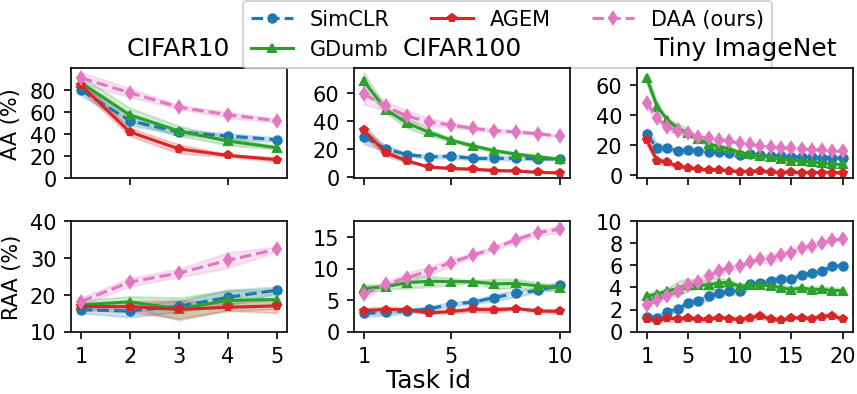

In [24]:
n_row = 2
n_col = 3
markersize=4

def mini_plot(ax, data, n_tasks):
    for method in data:
        y = data[method]
        x = list(range(1, len(y.mean(0)) + 1))
        label, marker, linestyle, color = get_legend(method)
        ax.plot(x, np.nan_to_num(y.mean(0)), label=label,
            marker=marker,  linestyle=linestyle, markersize=markersize, color=color)
        ax.fill_between(
            x,
            np.nan_to_num(y.mean(0)) - np.nan_to_num(y.std(0)),
            np.nan_to_num(y.mean(0)) + np.nan_to_num(y.std(0)),
            alpha=0.2,
            color=color
        )
    # ax.set_xticks([i for i in range(n_tasks)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # ax.set_xlabel("Task id")
    # ax.set_ylabel("Average Accuracy (%)")

fig, axes = plt.subplots(n_row, n_col, figsize=(6, 2.5))
mini_plot(axes[0,0], data_c10_aa, 5)
mini_plot(axes[1,0], data_c10_raa, 5)
mini_plot(axes[0,1], data_c100_aa, 10)
mini_plot(axes[1,1], data_c100_raa, 10)
mini_plot(axes[0,2], data_tiny_aa, 20)
mini_plot(axes[1,2], data_tiny_raa, 20)


cifar10_xt = [1, 2, 3, 4, 5]
cifar10_yt1 = [0, 20, 40, 60, 80]
cifar10_yt2 = [10, 20, 30, 40]
axes[0,0].set_yticks(cifar10_yt1)
axes[0,0].set_yticklabels(cifar10_yt1)
axes[0,0].set_ylabel("AA (%)")
axes[0,0].set_title("CIFAR10")

axes[1,0].set_yticks(cifar10_yt2)
axes[1,0].set_yticklabels(cifar10_yt2)
axes[1,0].set_ylabel("RAA (%)")
axes[1,0].set_xticks(cifar10_xt)
axes[1,0].set_xticklabels(cifar10_xt)


cifar100_xt = [1, 5, 10]
cifar100_yt1 = [0, 20, 40, 60]
cifar100_yt2 = [0, 5, 10, 15]
axes[0,1].set_yticks(cifar100_yt1)
axes[0,1].set_yticklabels(cifar100_yt1)
axes[0,1].set_title("CIFAR100")
axes[0,1].set_xticks(cifar100_xt)

axes[1,1].set_yticks(cifar100_yt2)
axes[1,1].set_yticklabels(cifar100_yt2)
axes[1,1].set_xticks(cifar100_xt)
axes[1,1].set_xticklabels(cifar100_xt)

tiny_xt = [1, 5, 10, 15, 20]
tiny_yt1 = [0, 20, 40, 60]
tiny_yt2 = [0, 2, 4, 6, 8, 10]
axes[0,2].set_yticks(tiny_yt1)
axes[0,2].set_yticklabels(tiny_yt1)
axes[0,2].set_title("Tiny ImageNet")
axes[0,2].set_xticks(tiny_xt)

axes[1,2].set_yticks(tiny_yt2)
axes[1,2].set_yticklabels(tiny_yt2)
axes[1,2].set_xticks(tiny_xt)
axes[1,2].set_xticklabels(tiny_xt)

fig.tight_layout()
fig.supxlabel("Task id",y=-0.01)
axes[0,0].legend(bbox_to_anchor=(0.75, 1.7),
                   loc="upper left",
                   ncol=3
                  )

### AF and RAF

In [28]:
data_c10_af = load_data(
    tags=tags,
    dataset='cifar10',
    n_classes=10,
    mi=1,
    mem_size=200,
    n_runs=5,
    n_tasks=5,
    data_root='../results/',
    metric='fgt',
)
data_c10_raf = load_data(
    tags=tags,
    dataset='cifar10',
    n_classes=10,
    mi=1,
    mem_size=200,
    n_runs=5,
    n_tasks=5,
    data_root='../results/',
    metric='raf',
)
data_c100_af = load_data(
    tags=tags,
    dataset='cifar100',
    n_classes=100,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=10,
    data_root='../results/',
    metric='fgt',
)
data_c100_raf = load_data(
    tags=tags,
    dataset='cifar100',
    n_classes=100,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=10,
    data_root='../results/',
    metric='raf',
)
data_tiny_af = load_data(
    tags=tags,
    dataset='tiny',
    n_classes=200,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=20,
    data_root='../results/',
    metric='fgt',
)
data_tiny_raf = load_data(
    tags=tags,
    dataset='tiny',
    n_classes=200,
    mi=1,
    mem_size=2000,
    n_runs=5,
    n_tasks=20,
    data_root='../results/',
    metric='raf',
)

/tmp/ipykernel_1965926/4276974413.py:53: RuntimeWarning: Mean of empty slice
  y = np.nan_to_num(np.nanmean(data[method], axis=2))
/home/micheln/projects/daa/notebooks/../src/utils/metrics.py:43: RuntimeWarning: Mean of empty slice
  rand_perf = np.nan_to_num(np.nanmean(forgetting_table(df, n_tasks).values, 1))
/home/micheln/projects/daa/notebooks/../src/utils/metrics.py:43: RuntimeWarning: Mean of empty slice
  rand_perf = np.nan_to_num(np.nanmean(forgetting_table(df, n_tasks).values, 1))
/home/micheln/projects/daa/notebooks/../src/utils/metrics.py:43: RuntimeWarning: Mean of empty slice
  rand_perf = np.nan_to_num(np.nanmean(forgetting_table(df, n_tasks).values, 1))
/home/micheln/projects/daa/notebooks/../src/utils/metrics.py:43: RuntimeWarning: Mean of empty slice
  rand_perf = np.nan_to_num(np.nanmean(forgetting_table(df, n_tasks).values, 1))
/home/micheln/projects/daa/notebooks/../src/utils/metrics.py:43: RuntimeWarning: Mean of empty slice
  rand_perf = np.nan_to_num(np.nanmean(f

/home/micheln/envs/ucl/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/micheln/envs/ucl/lib/python3.8/site-packages/matplotlib/axes/_base.py:2960: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


/home/micheln/envs/ucl/lib/python3.8/site-packages/matplotlib/transforms.py:371: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 1] - points[0, 1]


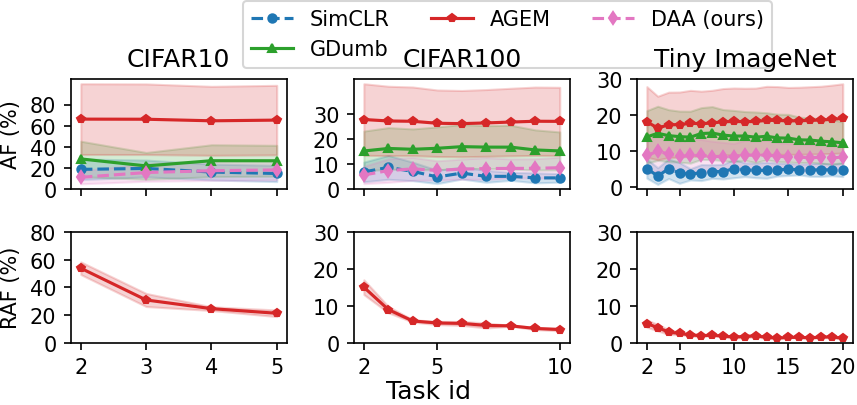

In [29]:
n_row = 2
n_col = 3
markersize=4

def mini_plot(ax, data, n_tasks):
    for method in data:
        y = data[method]
        x = list(range(1, len(y.mean(0)) + 1))
        x = x[1:]
        label, marker, linestyle, color = get_legend(method)
        ax.plot(x, np.nan_to_num(y.mean(0)[1:]), label=label,
            marker=marker,  linestyle=linestyle, markersize=markersize, color=color)
        ax.fill_between(
            x,
            np.nan_to_num(y.mean(0)[1:]) - np.nan_to_num(y.std(0)[1:]),
            np.nan_to_num(y.mean(0)[1:]) + np.nan_to_num(y.std(0)[1:]),
            alpha=0.2,
            color=color
        )
    # ax.set_xticks([i for i in range(n_tasks)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # ax.set_xlabel("Task id")
    # ax.set_ylabel("Average Accuracy (%)")

fig, axes = plt.subplots(n_row, n_col, figsize=(6, 2.5))
mini_plot(axes[0,0], data_c10_af, 5)
mini_plot(axes[1,0], data_c10_raf, 5)
mini_plot(axes[0,1], data_c100_af, 10)
mini_plot(axes[1,1], data_c100_raf, 10)
mini_plot(axes[0,2], data_tiny_af, 20)
mini_plot(axes[1,2], data_tiny_raf, 20)


cifar10_xt = [2, 3, 4, 5]
cifar10_yt1 = [0, 20, 40, 60, 80]
cifar10_yt2 = [0, 20, 40, 60, 80]
axes[0,0].set_yticks(cifar10_yt1)
axes[0,0].set_yticklabels(cifar10_yt1)
axes[0,0].set_xticks(cifar10_xt)
axes[0,0].set_ylabel("AF (%)")
axes[0,0].set_title("CIFAR10")

axes[1,0].set_yticks(cifar10_yt2)
axes[1,0].set_yticklabels(cifar10_yt2)
axes[1,0].set_ylabel("RAF (%)")
axes[1,0].set_xticks(cifar10_xt)
axes[1,0].set_xticklabels(cifar10_xt)


cifar100_xt = [2, 5, 10]
cifar100_yt1 = [0, 10, 20, 30]
cifar100_yt2 = [0, 10, 20, 30]
axes[0,1].set_yticks(cifar100_yt1)
axes[0,1].set_yticklabels(cifar100_yt1)
axes[0,1].set_title("CIFAR100")
axes[0,1].set_xticks(cifar100_xt)

axes[1,1].set_yticks(cifar100_yt2)
axes[1,1].set_yticklabels(cifar100_yt2)
axes[1,1].set_xticks(cifar100_xt)
axes[1,1].set_xticklabels(cifar100_xt)

tiny_xt = [2, 5, 10, 15, 20]
tiny_yt1 = [0, 10, 20, 30]
tiny_yt2 = [0, 10, 20, 30]
axes[0,2].set_yticks(tiny_yt1)
axes[0,2].set_yticklabels(tiny_yt1)
axes[0,2].set_title("Tiny ImageNet")
axes[0,2].set_xticks(tiny_xt)

axes[1,2].set_yticks(tiny_yt2)
axes[1,2].set_yticklabels(tiny_yt2)
axes[1,2].set_xticks(tiny_xt)
axes[1,2].set_xticklabels(tiny_xt)

fig.tight_layout()
fig.supxlabel("Task id",y=-0.01)
axes[0,0].legend(bbox_to_anchor=(0.75, 1.8),
                   loc="upper left",
                   ncol=3
                  )


#### grouped

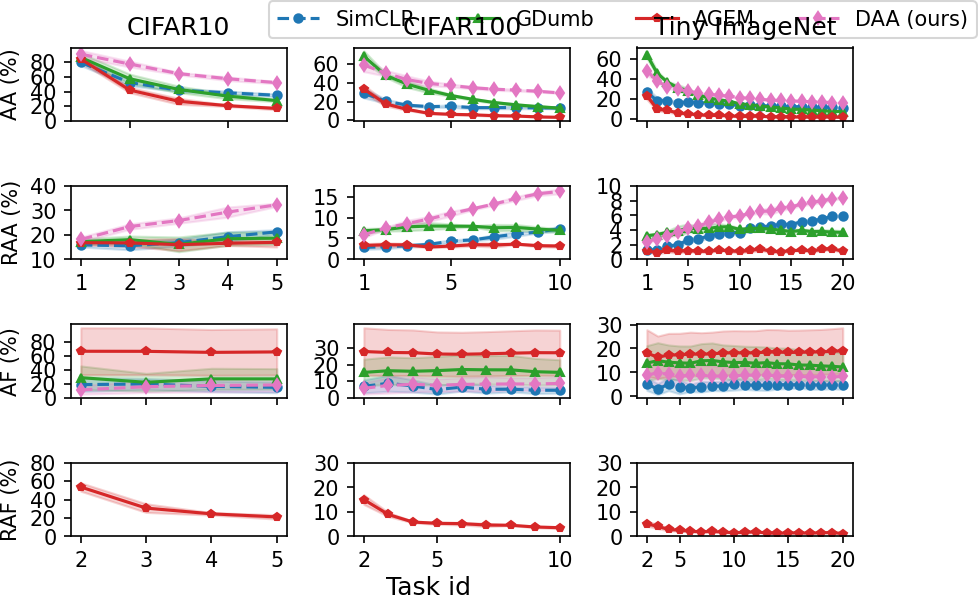

In [31]:
n_row = 4
n_col = 3
markersize=4

def mini_plot(ax, data, n_tasks, start=0):
    for method in data:
        y = data[method]
        x = list(range(1, len(y.mean(0)) + 1))
        x = x[start:]
        label, marker, linestyle, color = get_legend(method)
        ax.plot(x, np.nan_to_num(y.mean(0)[start:]), label=label,
            marker=marker,  linestyle=linestyle, markersize=markersize, color=color)
        ax.fill_between(
            x,
            np.nan_to_num(y.mean(0)[start:]) - np.nan_to_num(y.std(0)[start:]),
            np.nan_to_num(y.mean(0)[start:]) + np.nan_to_num(y.std(0)[start:]),
            alpha=0.2,
            color=color
        )
    # ax.set_xticks([i for i in range(n_tasks)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # ax.set_xlabel("Task id")
    # ax.set_ylabel("Average Accuracy (%)")

fig, axes = plt.subplots(n_row, n_col, figsize=(6, 4))
# ACCURACY
mini_plot(axes[0,0], data_c10_aa, 5)
mini_plot(axes[1,0], data_c10_raa, 5)
mini_plot(axes[0,1], data_c100_aa, 10)
mini_plot(axes[1,1], data_c100_raa, 10)
mini_plot(axes[0,2], data_tiny_aa, 20)
mini_plot(axes[1,2], data_tiny_raa, 20)

cifar10_xt = [1, 2, 3, 4, 5]
cifar10_yt1 = [0, 20, 40, 60, 80]
cifar10_yt2 = [10, 20, 30, 40]
axes[0,0].set_yticks(cifar10_yt1)
axes[0,0].set_yticklabels(cifar10_yt1)
axes[0,0].set_ylabel("AA (%)")
axes[0,0].set_title("CIFAR10")

axes[1,0].set_yticks(cifar10_yt2)
axes[1,0].set_yticklabels(cifar10_yt2)
axes[1,0].set_ylabel("RAA (%)")
axes[1,0].set_xticks(cifar10_xt)
axes[1,0].set_xticklabels(cifar10_xt)

cifar100_xt = [1, 5, 10]
cifar100_yt1 = [0, 20, 40, 60]
cifar100_yt2 = [0, 5, 10, 15]
axes[0,1].set_yticks(cifar100_yt1)
axes[0,1].set_yticklabels(cifar100_yt1)
axes[0,1].set_title("CIFAR100")
axes[0,1].set_xticks(cifar100_xt)

axes[1,1].set_yticks(cifar100_yt2)
axes[1,1].set_yticklabels(cifar100_yt2)
axes[1,1].set_xticks(cifar100_xt)
axes[1,1].set_xticklabels(cifar100_xt)

tiny_xt = [1, 5, 10, 15, 20]
tiny_yt1 = [0, 20, 40, 60]
tiny_yt2 = [0, 2, 4, 6, 8, 10]
axes[0,2].set_yticks(tiny_yt1)
axes[0,2].set_yticklabels(tiny_yt1)
axes[0,2].set_title("Tiny ImageNet")
axes[0,2].set_xticks(tiny_xt)

axes[1,2].set_yticks(tiny_yt2)
axes[1,2].set_yticklabels(tiny_yt2)
axes[1,2].set_xticks(tiny_xt)
axes[1,2].set_xticklabels(tiny_xt)

# FORGETTING
mini_plot(axes[2,0], data_c10_af, 5, start=1)
mini_plot(axes[3,0], data_c10_raf, 5, start=1)
mini_plot(axes[2,1], data_c100_af, 10, start=1)
mini_plot(axes[3,1], data_c100_raf, 10, start=1)
mini_plot(axes[2,2], data_tiny_af, 20, start=1)
mini_plot(axes[3,2], data_tiny_raf, 20, start=1)

cifar10_xt = [2, 3, 4, 5]
cifar10_yt1 = [0, 20, 40, 60, 80]
cifar10_yt2 = [0, 20, 40, 60, 80]
axes[2,0].set_yticks(cifar10_yt1)
axes[2,0].set_yticklabels(cifar10_yt1)
axes[2,0].set_xticks(cifar10_xt)
axes[2,0].set_ylabel("AF (%)")
# axes[2,0].set_title("CIFAR10")

axes[3,0].set_yticks(cifar10_yt2)
axes[3,0].set_yticklabels(cifar10_yt2)
axes[3,0].set_ylabel("RAF (%)")
axes[3,0].set_xticks(cifar10_xt)
axes[3,0].set_xticklabels(cifar10_xt)

cifar100_xt = [2, 5, 10]
cifar100_yt1 = [0, 10, 20, 30]
cifar100_yt2 = [0, 10, 20, 30]
axes[2,1].set_yticks(cifar100_yt1)
axes[2,1].set_yticklabels(cifar100_yt1)
# axes[2,1].set_title("CIFAR100")
axes[2,1].set_xticks(cifar100_xt)

axes[3,1].set_yticks(cifar100_yt2)
axes[3,1].set_yticklabels(cifar100_yt2)
axes[3,1].set_xticks(cifar100_xt)
axes[3,1].set_xticklabels(cifar100_xt)

tiny_xt = [2, 5, 10, 15, 20]
tiny_yt1 = [0, 10, 20, 30]
tiny_yt2 = [0, 10, 20, 30]
axes[2,2].set_yticks(tiny_yt1)
axes[2,2].set_yticklabels(tiny_yt1)
# axes[2,2].set_title("Tiny ImageNet")
axes[2,2].set_xticks(tiny_xt)

axes[3,2].set_yticks(tiny_yt2)
axes[3,2].set_yticklabels(tiny_yt2)
axes[3,2].set_xticks(tiny_xt)
axes[3,2].set_xticklabels(tiny_xt)

fig.tight_layout()
fig.supxlabel("Task id",y=-0.01)
axes[0,0].legend(bbox_to_anchor=(0.87, 1.77),
                   loc="upper left",
                   ncol=6
                  )


#### grouped2

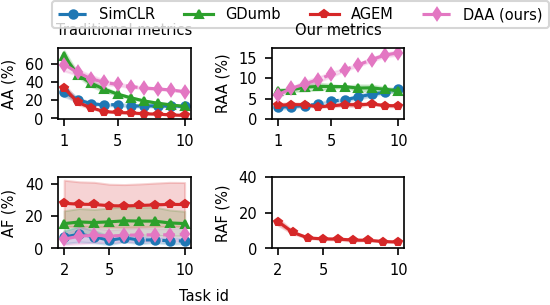

In [32]:
n_row = 2
n_col = 2
markersize=4

def mini_plot(ax, data, n_tasks, start=0):
    for method in data:
        y = data[method]
        x = list(range(1, len(y.mean(0)) + 1))
        x = x[start:]
        label, marker, linestyle, color = get_legend(method)
        ax.plot(x, np.nan_to_num(y.mean(0)[start:]), label=label,
            marker=marker,  linestyle=linestyle, markersize=markersize, color=color)
        ax.fill_between(
            x,
            np.nan_to_num(y.mean(0)[start:]) - np.nan_to_num(y.std(0)[start:]),
            np.nan_to_num(y.mean(0)[start:]) + np.nan_to_num(y.std(0)[start:]),
            alpha=0.2,
            color=color
        )
    # ax.set_xticks([i for i in range(n_tasks)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # ax.set_xlabel("Task id")
    # ax.set_ylabel("Average Accuracy (%)")

fig, axes = plt.subplots(n_row, n_col, figsize=(3, 2))
# ACCURACY
mini_plot(axes[0,0], data_c100_aa, 10)
mini_plot(axes[1,0], data_c100_af, 10, start=1)
mini_plot(axes[0,1], data_c100_raa, 10)
mini_plot(axes[1,1], data_c100_raf, 10, start=1)

cifar100_xa = [1, 5, 10]
cifar100_xf = [2, 5, 10]
cifar100_yt1 = [0, 20, 40, 60]
cifar100_yt2 = [0, 5, 10, 15]
# cifar100_yt2 = [0, 20, 40]
axes[0,0].set_yticks(cifar100_yt1, fontsize=7)
axes[0,0].set_yticklabels(cifar100_yt1, fontsize=7)
axes[0,0].set_ylabel("AA (%)", fontsize=7)
axes[0,0].set_title("Traditional metrics", fontsize=7)
axes[0,0].set_xticks(cifar100_xa, fontsize=7)
axes[0,0].set_xticklabels(cifar100_xa, fontsize=7)

axes[1,0].set_yticks([0, 20, 40], fontsize=7)
axes[1,0].set_yticklabels([0, 20, 40], fontsize=7)
axes[1,0].set_ylabel("AF (%)", fontsize=7)
axes[1,0].set_xticks(cifar100_xf, fontsize=7)
axes[1,0].set_xticklabels(cifar100_xf, fontsize=7)

axes[0,1].set_yticks(cifar100_yt2, fontsize=7)
axes[0,1].set_yticklabels(cifar100_yt2, fontsize=7)
axes[0,1].set_title("Our metrics", fontsize=7)
axes[0,1].set_ylabel("RAA (%)", fontsize=7)
axes[0,1].set_xticks(cifar100_xa, fontsize=7)
axes[0,1].set_xticklabels(cifar100_xa, fontsize=7)

axes[1,1].set_yticks([0, 20, 40], fontsize=7)
axes[1,1].set_yticklabels([0, 20, 40], fontsize=7)
axes[1,1].set_xticks(cifar100_xf, fontsize=7)
axes[1,1].set_ylabel("RAF (%)", fontsize=7)
axes[1,1].set_xticklabels(cifar100_xf, fontsize=7)

fig.tight_layout()
fig.supxlabel("Task id",y=-0.01, fontsize=7)
axes[0,0].legend(bbox_to_anchor=(-0.1, 1.75),
                   loc="upper left",
                   ncol=6,
                   fontsize=7
                  )


## Table generation

In [33]:
# BASELINES = ['er', 'scr', 'agem', 'gdumb', 'stam', 'lump', '2aug']
BASELINES = ['er', 'scr', 'agem', 'gdumb', 'lump', '2aug']
OURS = ['4aug,1mixup,1cutmix,1style']
DATASET=['cifar10', 'cifar100', 'tiny']
MEM_SIZE={
    'cifar10': [200, 500],
    'cifar100': [2000, 5000],
    'tiny': [2000, 5000, 10000]
}
N_TASK = {
    'cifar10': 5,
    'cifar100': 10,
    'tiny': 20
}
N_CLASS = {
    'cifar10': 5,
    'cifar100': 10,
    'tiny': 20
}
data_root = '../results/'

def final_acc(data, method):
    return round(np.array(data[method])[:,-1].mean(), 3), \
            round(np.array(data[method])[:,-1].std(), 3)

In [35]:
table_data = {}
all_lines = []
for dataset in DATASET:
    for m in MEM_SIZE[dataset]:
        data = load_data(
            tags=BASELINES,
            tags20=OURS,
            dataset=dataset,
            n_classes=N_CLASS[dataset],
            mi=1,
            mem_size=m,
            n_runs=5,
            run_id=0,
            n_tasks=N_TASK[dataset],
            data_root=data_root,
            metric='acc',
        )
        for method in data:
            mean, std = final_acc(data, method)
            latex = f"{np.round(mean,2)}$\\pm${np.round(std,1)}"
            line = [dataset, m, method, mean, std, latex]
            all_lines.append(line)
df = pd.DataFrame(all_lines, columns=['dataset', 'Memory size', 'method', 'mean', 'std', 'latex'])

In [36]:
df

,dataset,Memory size,method,mean,std,latex
0,cifar10,200,er,35.388,3.089,35.39$\pm$3.1
1,cifar10,200,scr,38.730,2.477,38.73$\pm$2.5
2,cifar10,200,agem,16.990,1.919,16.99$\pm$1.9
3,cifar10,200,gdumb,27.716,1.601,27.72$\pm$1.6
4,cifar10,200,lump,31.828,0.691,31.83$\pm$0.7
5,cifar10,200,2aug,34.892,1.816,34.89$\pm$1.8
6,cifar10,200,"4aug,1mixup,1cutmix,1style",52.100,1.590,52.1$\pm$1.6
7,cifar10,500,er,35.142,3.864,35.14$\pm$3.9
8,cifar10,500,scr,43.716,2.229,43.72$\pm$2.2
9,cifar10,500,agem,17.344,1.095,17.34$\pm$1.1


In [37]:
ds = 'cifar10'
mem_size = 200
df[df['dataset'] == ds][df['Memory size'] == mem_size]

/tmp/ipykernel_1965926/4275608842.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['dataset'] == ds][df['Memory size'] == mem_size]


,dataset,Memory size,method,mean,std,latex
0,cifar10,200,er,35.388,3.089,35.39$\pm$3.1
1,cifar10,200,scr,38.730,2.477,38.73$\pm$2.5
2,cifar10,200,agem,16.990,1.919,16.99$\pm$1.9
3,cifar10,200,gdumb,27.716,1.601,27.72$\pm$1.6
4,cifar10,200,lump,31.828,0.691,31.83$\pm$0.7
5,cifar10,200,2aug,34.892,1.816,34.89$\pm$1.8
6,cifar10,200,"4aug,1mixup,1cutmix,1style",52.100,1.590,52.1$\pm$1.6


In [68]:
ds = 'cifar10'
mem_size = 500
df[df['dataset'] == ds][df['Memory size'] == mem_size]

,dataset,Memory size,method,mean,std,latex
7,cifar10,500,er,35.142,3.864,35.14$\pm$3.9
8,cifar10,500,scr,43.716,2.229,43.72$\pm$2.2
9,cifar10,500,agem,17.344,1.095,17.34$\pm$1.1
10,cifar10,500,gdumb,31.604,1.515,31.6$\pm$1.5
11,cifar10,500,lump,31.722,2.595,31.72$\pm$2.6
12,cifar10,500,2aug,33.450,2.572,33.45$\pm$2.6
13,cifar10,500,"4aug,1mixup,1cutmix,1style",57.158,0.800,57.16$\pm$0.8


In [69]:
ds = 'cifar100'
mem_size = 2000
df[df['dataset'] == ds][df['Memory size'] == mem_size]

,dataset,Memory size,method,mean,std,latex
14,cifar100,2000,er,5.648,0.414,5.65$\pm$0.4
15,cifar100,2000,scr,15.078,1.037,15.08$\pm$1.0
16,cifar100,2000,agem,3.202,0.322,3.2$\pm$0.3
17,cifar100,2000,gdumb,12.946,0.967,12.95$\pm$1.0
18,cifar100,2000,lump,12.568,0.886,12.57$\pm$0.9
19,cifar100,2000,2aug,13.180,0.950,13.18$\pm$1.0
20,cifar100,2000,"4aug,1mixup,1cutmix,1style",29.248,0.624,29.25$\pm$0.6


In [70]:
ds = 'cifar100'
mem_size = 5000
df[df['dataset'] == ds][df['Memory size'] == mem_size]

,dataset,Memory size,method,mean,std,latex
21,cifar100,5000,er,5.700,0.840,5.7$\pm$0.8
22,cifar100,5000,scr,15.862,0.289,15.86$\pm$0.3
23,cifar100,5000,agem,3.284,0.299,3.28$\pm$0.3
24,cifar100,5000,gdumb,20.798,0.844,20.8$\pm$0.8
25,cifar100,5000,lump,13.220,0.650,13.22$\pm$0.6
26,cifar100,5000,2aug,12.774,1.106,12.77$\pm$1.1
27,cifar100,5000,"4aug,1mixup,1cutmix,1style",30.054,0.394,30.05$\pm$0.4


In [71]:
ds = 'tiny'
mem_size = 2000
df[df['dataset'] == ds][df['Memory size'] == mem_size]

,dataset,Memory size,method,mean,std,latex
28,tiny,2000,er,1.864,0.178,1.86$\pm$0.2
29,tiny,2000,scr,9.722,0.570,9.72$\pm$0.6
30,tiny,2000,agem,1.118,0.174,1.12$\pm$0.2
31,tiny,2000,gdumb,7.022,0.337,7.02$\pm$0.3
32,tiny,2000,lump,8.270,0.668,8.27$\pm$0.7
33,tiny,2000,2aug,11.038,0.123,11.04$\pm$0.1
34,tiny,2000,"4aug,1mixup,1cutmix,1style",15.676,0.168,15.68$\pm$0.2


In [72]:
ds = 'tiny'
mem_size = 5000
df[df['dataset'] == ds][df['Memory size'] == mem_size]

,dataset,Memory size,method,mean,std,latex
35,tiny,5000,er,2.096,0.148,2.1$\pm$0.1
36,tiny,5000,scr,11.624,0.419,11.62$\pm$0.4
37,tiny,5000,agem,1.468,0.273,1.47$\pm$0.3
38,tiny,5000,gdumb,13.034,0.252,13.03$\pm$0.3
39,tiny,5000,lump,8.156,0.646,8.16$\pm$0.6
40,tiny,5000,2aug,11.190,0.500,11.19$\pm$0.5
41,tiny,5000,"4aug,1mixup,1cutmix,1style",16.812,0.790,16.81$\pm$0.8


In [73]:
ds = 'tiny'
mem_size = 10000
df[df['dataset'] == ds][df['Memory size'] == mem_size]

,dataset,Memory size,method,mean,std,latex
42,tiny,10000,er,1.898,0.149,1.9$\pm$0.1
43,tiny,10000,scr,12.078,0.434,12.08$\pm$0.4
44,tiny,10000,agem,1.194,0.259,1.19$\pm$0.3
45,tiny,10000,gdumb,20.728,0.758,20.73$\pm$0.8
46,tiny,10000,lump,8.442,0.423,8.44$\pm$0.4
47,tiny,10000,2aug,10.896,0.408,10.9$\pm$0.4
48,tiny,10000,"4aug,1mixup,1cutmix,1style",17.064,0.660,17.06$\pm$0.7
